In [1]:
import numpy as np
# import cupy as cp
import os
import torch
import pickle
from tqdm.auto import tqdm

embeds_names = ['embeddings_mobilefacenet',
'embeddings_DW_seesawFaceNetv2',
 'embeddings_reimplementation_seesawnet',
 'embeddings_seesaw_shareFaceNet_160',
 'embeddings_seesaw_shuffleFaceNet_160',
 'embeddings_seesaw_shuffleFaceNet_192',]



In [2]:
def euclidean_dist(x1, x2):
    return torch.linalg.norm(x1 - x2, dim=1)


def accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])




In [3]:
import matplotlib.pyplot as plt
from sklearn import metrics


def model_result(name):
    embed_paths = []
    embed_label = []
    
    print("Loading .npy files...")
    for idx, person_name in tqdm(enumerate(os.listdir(name)), total = len(os.listdir(name))):
        for img_name in os.listdir(name+'/'+person_name):
            embed_paths.append(np.load(f"{name}/{person_name}/{img_name}"))
            embed_label.append(idx)

    embed_paths = torch.FloatTensor(embed_paths).cuda()
    embed_label = torch.FloatTensor(embed_label).cuda()

    dist = []
    target = []

    print("Finding Euclidean Distances...")

    for x_embed, x_label in tqdm(zip(embed_paths, embed_label), total=len(embed_label)):
        dist.append(euclidean_dist(x_embed.view(1,-1).repeat(len(embed_paths),1), embed_paths))
        target.append(embed_label == x_label)

    dist_arr = []
    label_arr = []
    
    for i,j in tqdm(zip(dist, target), total=len(dist)):
        dist_ = []
        target_ = []
        n_matching = 0
        n_notmatching = 0

        for x,y in zip(i.detach().cpu().tolist(), j.detach().cpu().tolist()):
            if y is True: #matches
                target_.append(0)
                dist_.append(x)
                n_matching+=1

            elif y is False and n_matching>n_notmatching:
                target_.append(1)
                dist_.append(x)    
                n_notmatching+=1

            if y is False and n_notmatching==n_matching and n_matching!=0:
                break

        # if n_matching>n_notmatching:
        #     dist_.extend(i.detach().cpu().tolist()[:n_matching-n_notmatching])     
        #     target_.extend((n_matching-n_notmatching)*[0])  

        dist_arr.extend(dist_)
        label_arr.extend(target_)


    print(len(dist_arr), len(label_arr))
    max_, min_ = max(dist_arr), min(dist_arr)

    
    analysis = {}

    print("Finding Optimal threshold...")

    fpr, tpr, thresholds = metrics.roc_curve(label_arr, dist_arr, pos_label=1)

    

    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
    plt.show()


    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    gmeanOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)
    
    print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
    print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

    # for ith_threshold in tqdm(np.linspace(min_, max_, 500)):
    #     TP, TN, FP, FN = 0, 0, 0, 0
    #     for i in tqdm(range(len(dist_arr)), leave=False):
    #         if dist_arr[i]>=ith_threshold:
    #             if label_arr[i] == 1:
    #                 TP+=1
    #             else:
    #                 FP+=1

    #         else:
    #             if label_arr[i] == 0:
    #                 TN+=1
    #             else:
    #                 FN+=1

    #     x = [TP, TN, FP, FN]

    #     analysis[ith_threshold] = x

    # pickle.dump(analysis, open(f"{name}.pkl", 'wb'))


1 embeddings_mobilefacenet
Loading .npy files...


100%|██████████| 5715/5715 [01:05<00:00, 87.17it/s] 
C:\Users\GOKULA~1\AppData\Local\Temp/ipykernel_13156/4200152890.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  embed_paths = torch.FloatTensor(embed_paths).cuda()


Finding Euclidean Distances...


100%|██████████| 13137/13137 [00:13<00:00, 973.51it/s]


986257 986257
Finding Optimal threshold...


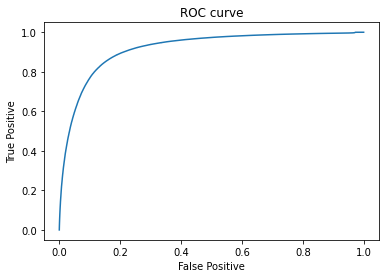

Best Threshold: 48.703 with G-Mean: 0.85
FPR: 0.1579, TPR: 0.8579
2 embeddings_DW_seesawFaceNetv2
Loading .npy files...


100%|██████████| 5749/5749 [01:15<00:00, 76.28it/s] 


Finding Euclidean Distances...


100%|██████████| 13233/13233 [00:15<00:00, 852.09it/s]


995493 995493
Finding Optimal threshold...


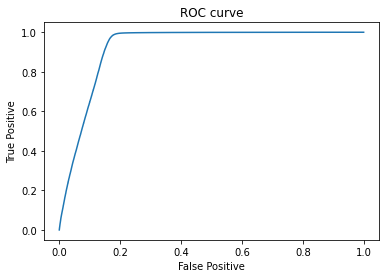

Best Threshold: 1.2418 with G-Mean: 0.9008
FPR: 0.1754, TPR: 0.984
3 embeddings_reimplementation_seesawnet
Loading .npy files...


100%|██████████| 5749/5749 [01:15<00:00, 76.55it/s] 


Finding Euclidean Distances...


100%|██████████| 13233/13233 [00:14<00:00, 911.28it/s]


995493 995493
Finding Optimal threshold...


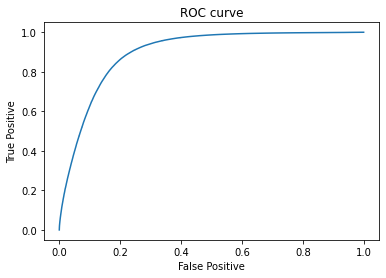

Best Threshold: 80.4722 with G-Mean: 0.8312
FPR: 0.2156, TPR: 0.8808
4 embeddings_seesaw_shareFaceNet_160
Loading .npy files...


100%|██████████| 5749/5749 [01:16<00:00, 75.51it/s] 


Finding Euclidean Distances...


100%|██████████| 13233/13233 [00:15<00:00, 861.00it/s]


995493 995493
Finding Optimal threshold...


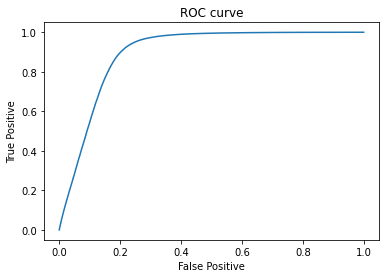

Best Threshold: 1.2574 with G-Mean: 0.8494
FPR: 0.2204, TPR: 0.9255
5 embeddings_seesaw_shuffleFaceNet_160
Loading .npy files...


100%|██████████| 5749/5749 [01:15<00:00, 75.96it/s] 


Finding Euclidean Distances...


100%|██████████| 13233/13233 [00:15<00:00, 849.26it/s]


995493 995493
Finding Optimal threshold...


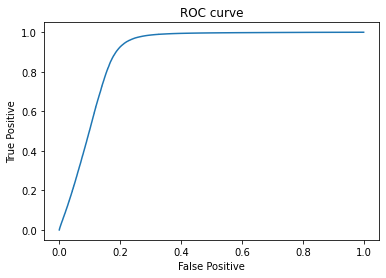

Best Threshold: 1.2461 with G-Mean: 0.8616
FPR: 0.2126, TPR: 0.9427
6 embeddings_seesaw_shuffleFaceNet_192
Loading .npy files...


100%|██████████| 5749/5749 [01:13<00:00, 78.45it/s] 


Finding Euclidean Distances...


100%|██████████| 13233/13233 [00:14<00:00, 900.91it/s]


995493 995493
Finding Optimal threshold...


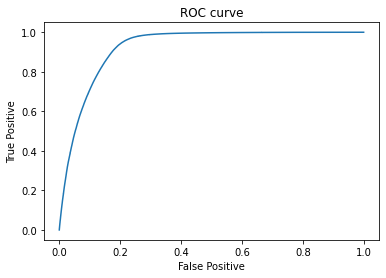

Best Threshold: 1.2628 with G-Mean: 0.8678
FPR: 0.1963, TPR: 0.937


In [4]:
for i, name in enumerate(embeds_names):
    print(i+1, name)
    model_result(name)

In [5]:
# _dist_arr = [i.detach().cpu().tolist() for i in dist]
# _label_arr = [i.detach().cpu().tolist() for i in target]

# dist_arr = []
# label_arr = []

# for i,j in tqdm(zip(dist, target), total=len(dist)):
#     dist_arr.extend(i.detach().cpu().tolist())
#     label_arr.extend([ 0 if i is False else 1 for i in j.detach().cpu().tolist()])

In [6]:
# postive_dist = [] # same face
# negative_dist = [] # different face

# for i,j in tqdm(zip(dist_arr, label_arr), total = len(dist_arr)):
#     if j is 1:
#         postive_dist.append(i)

#     else:
#         negative_dist.append(i)

In [7]:
# max_, min_ = max(dist_arr), min(dist_arr)

# max_, min_
# # max(negative_dist), min(negative_dist), max(postive_dist), min(postive_dist)

In [8]:
# from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(label_arr, dist_arr, pos_label=1)
# import matplotlib.pyplot as plt

# plt.plot(fpr, tpr)
# plt.title("ROC curve")
# plt.xlabel("False Positive")
# plt.ylabel("True Positive")
# plt.show()

# gmean = np.sqrt(tpr * (1 - fpr))

# # Find the optimal threshold
# index = np.argmax(gmean)
# thresholdOpt = round(thresholds[index], ndigits = 4)
# gmeanOpt = round(gmean[index], ndigits = 4)
# fprOpt = round(fpr[index], ndigits = 4)
# tprOpt = round(tpr[index], ndigits = 4)

# print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
# print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))